Install

In [1]:
#test
#(studiolab) studio-lab-user@default:~/sagemaker-studiolab-notebooks/AI-OT24$ tensorboard --logdir logs/
#!pip install -q ib_insync numpy pandas yfinance matplotlib ta seaborn gymnasium stable-baselines3 sb3-contrib tensorflow scikit-learn quantstats imitation fredapi typing


Install requirements and import all functions

In [1]:
import os
os.chdir("/home/studio-lab-user/sagemaker-studiolab-notebooks/AI-OT24/Reinforcement-Learning-Stock-Porfolio-Managment")
!pip install -q -r requirements.txt

In [2]:
import sys
sys.path.append('./utils')
from trading_functions import linear_schedule, TradingEnvUnique, TradingEnvUniqueMultiple, create_env, create_env_unique, evaluate_best, evaluate_buy, evaluate_model, evaluate_various, evaluate_all

SyntaxError: unterminated triple-quoted string literal (detected at line 1201) (trading_functions.py, line 1104)

Import

In [ ]:
# Core Libraries
import os
import sys
import time
import datetime
import warnings
#warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = info, 2 = warnings, 3 = errors

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# Financial Data
import yfinance as yf
import quantstats as qs
import ta

# Machine Learning - Supervised Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Machine Learning - Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy

# Reinforcement Learning and Environments
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import A2C, DDPG, DQN, HER, PPO, SAC, TD3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import (
    EvalCallback, StopTrainingOnRewardThreshold, StopTrainingOnNoModelImprovement
)
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecCheckNan
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from sb3_contrib import ARS, MaskablePPO, RecurrentPPO, QRDQN, TRPO

# Imitation Learning
from imitation.algorithms import bc
from imitation.testing.reward_improvement import is_significant_reward_improvement
from imitation.data.types import Transitions

# Interactive Brokers API
from ib_insync import *

from typing import Callable

from collections import Counter

clear_output()


API Fred

In [8]:
from fredapi import Fred
fred = Fred(api_key='xxxxxxxxxxxxxxx')

RL

Train
Total return of portfolio: 537.13%


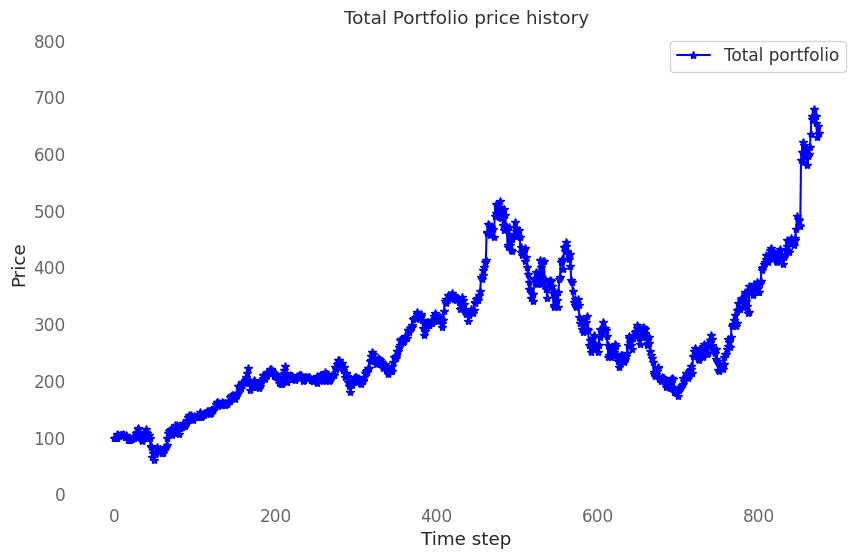

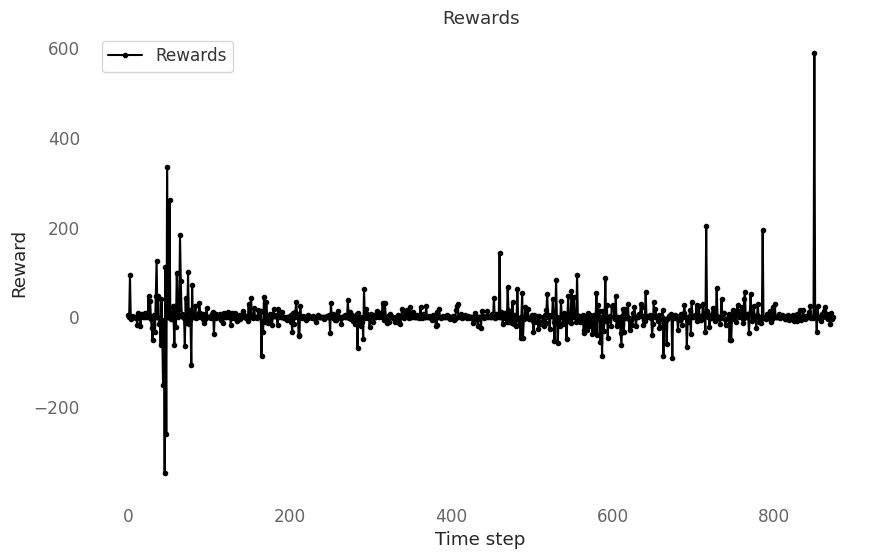

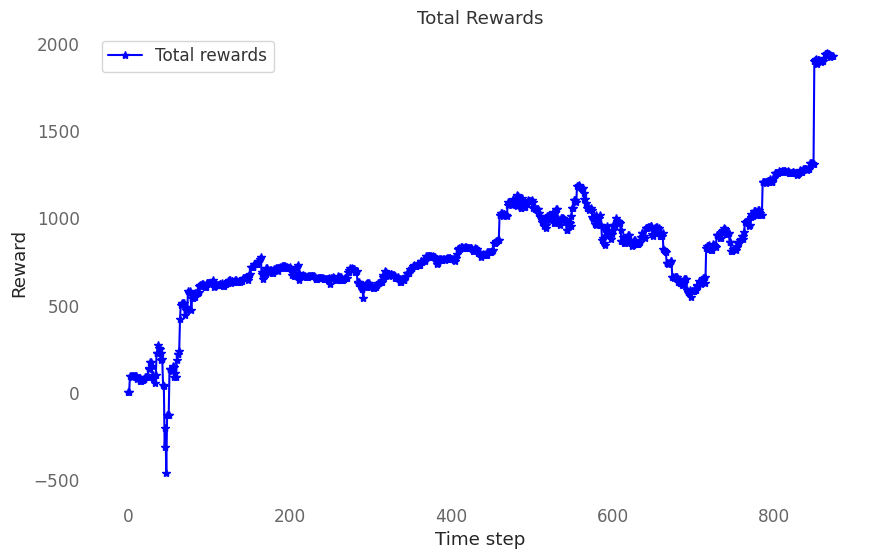

Total rewards: 1929.8087468772678
Valid
Total return of portfolio: -43.48%


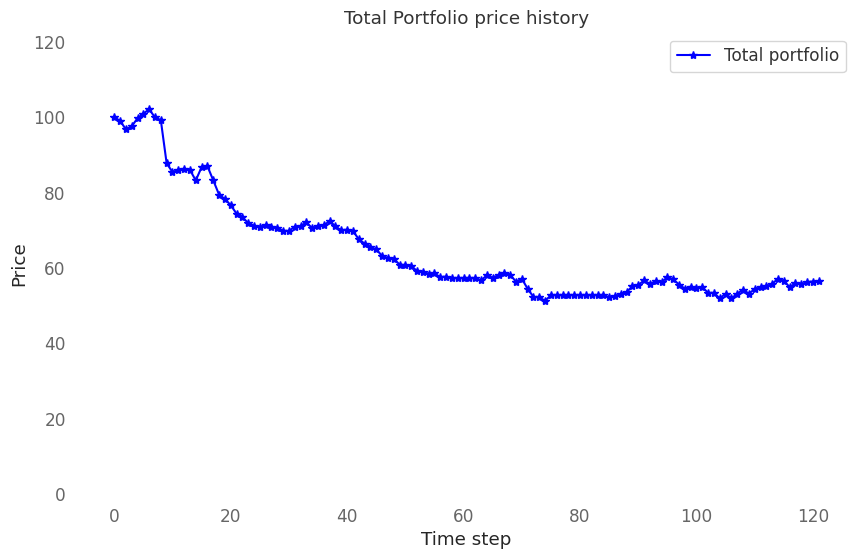

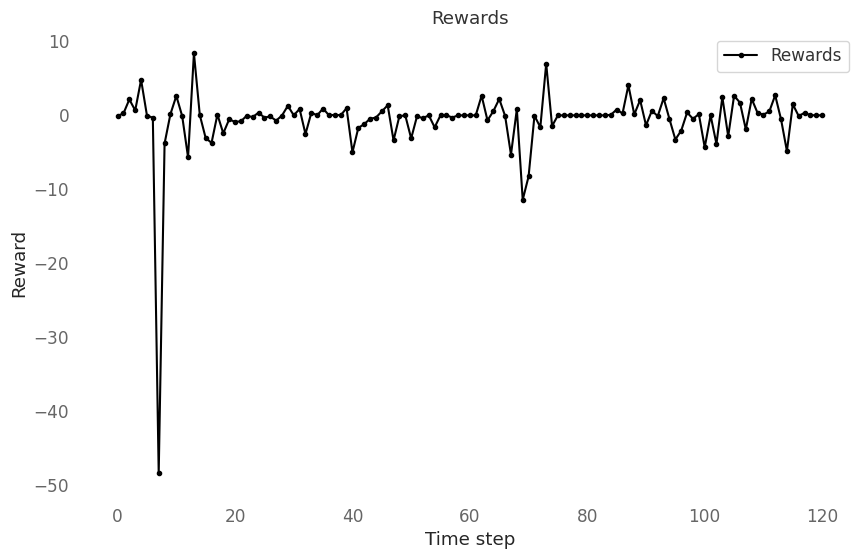

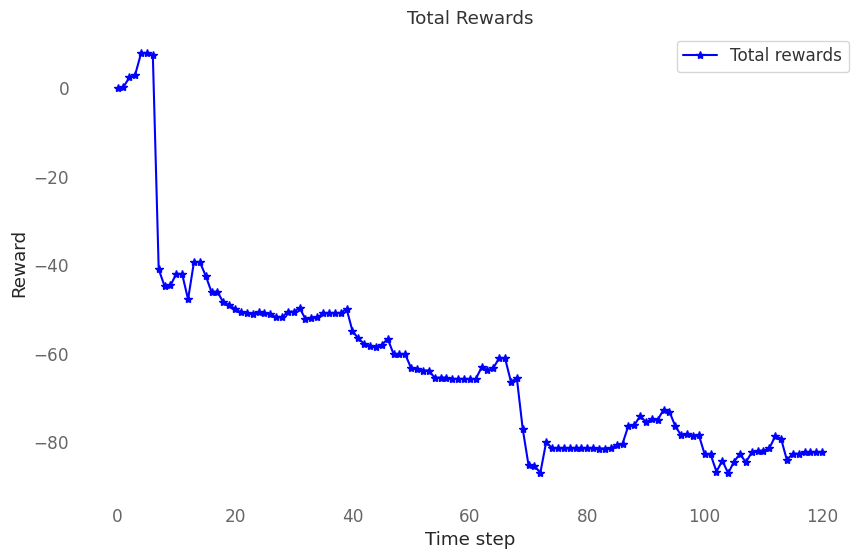

Total rewards: -82.25144228809992
Test
Total return of portfolio: 155.96%


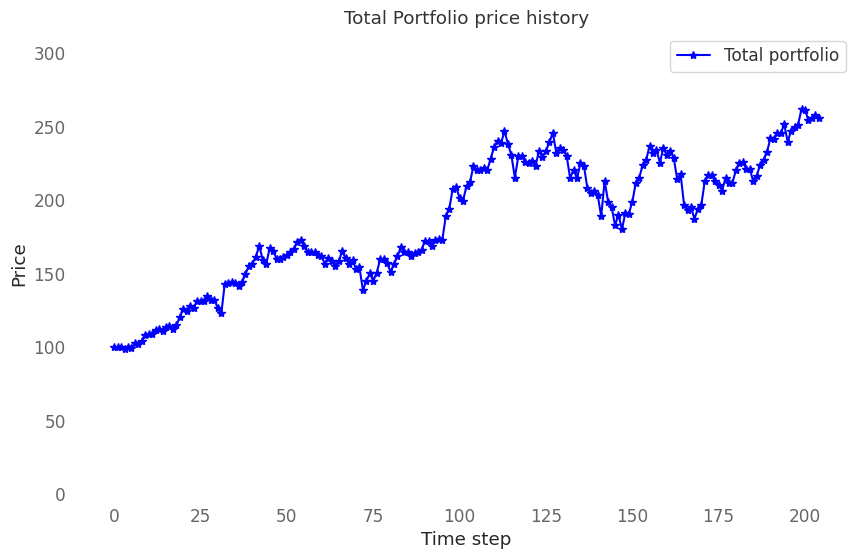

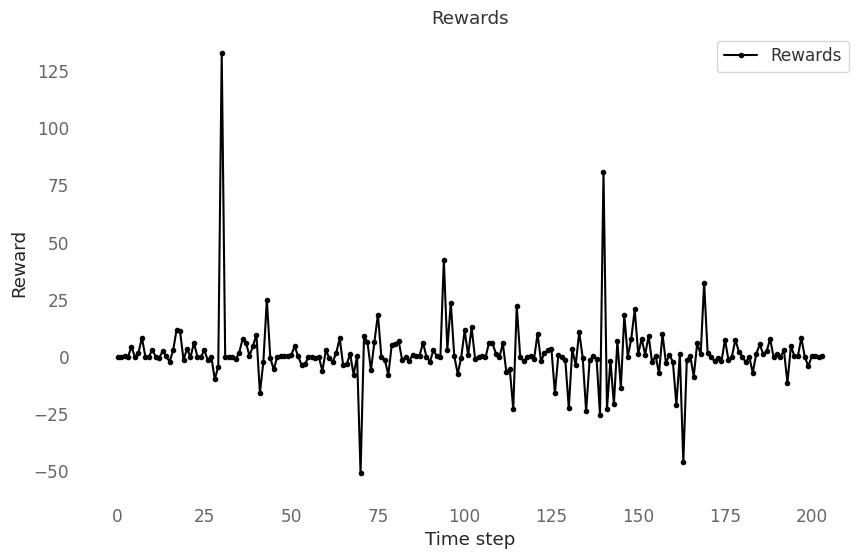

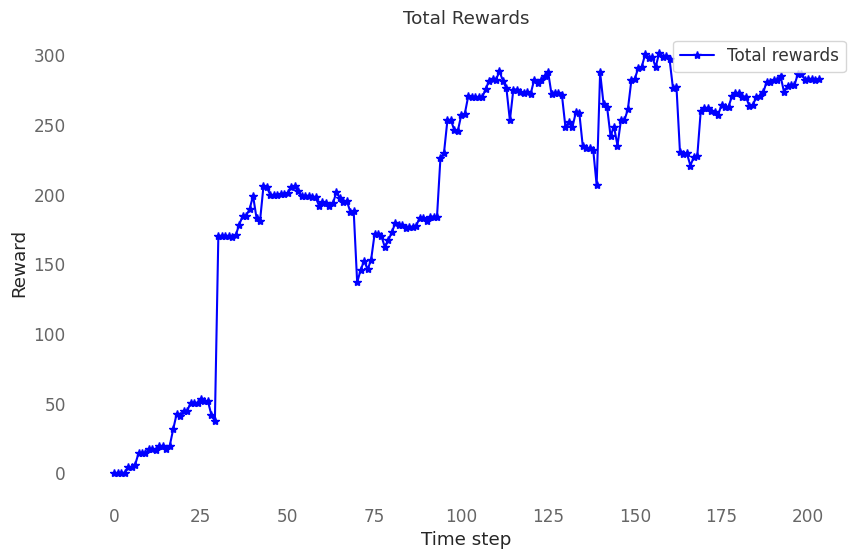

Total rewards: 282.5342168560254


In [10]:
# Define constants
SEED = 1
history_length = 5
reward_type = 'SQS'
stocks = ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'TSLA']
n_envs = 10
n_steps = 8
total_timesteps = 10_000
batch_size = 64
learning_rate = 0.001
ent_coef = 0.10
log_interval = 10_000
eval_freq=1_000
log_dir = './logs'
model_save_dir = './Tests'

# Training environment
env, vec_env = create_training_env(history_length, reward_type, '2020-01-01', '2023-06-30', stocks, n_envs)

# Validation environment
valid_env, vec_valid_env = create_evaluation_env(history_length, reward_type, '2023-07-01', '2023-12-30', stocks)

# Test environment
test_env, _ = create_evaluation_env(history_length, reward_type, '2024-01-01', '2024-10-30', stocks, n_envs=1)

# Evaluation callback for saving the best model
eval_callback = EvalCallback(
    vec_valid_env,
    n_eval_episodes=1,
    eval_freq=eval_freq,
    deterministic=True,
    verbose=1,
    best_model_save_path=model_save_dir,
)
stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)

# Train the model
model = train_model(
    model_name="PPO",  # Can be 'PPO', 'A2C', or 'DQN'
    create_model=True,
    vec_env=vec_env,
    iterations=1,
    train_timesteps=total_timesteps,
    log_frec=log_interval,
    log_base_dir=log_dir,
    n_steps=n_steps,
    batch_size=batch_size,
    learning_rate=learning_rate,
    ent_coef=ent_coef
)

# Evaluate the model
evaluate_model(model, env, 'Train', SEED, has_policy=False)
evaluate_model(model, valid_env, 'Valid', SEED, has_policy=False)
evaluate_model(model, test_env, 'Test', SEED, has_policy=False)

# Save the model to the Tests folder
save_model(model, model_save_dir)

# Close environments
env.close()
valid_env.close()
test_env.close()
vec_env.close()
vec_valid_env.close()

BC

In [3]:
# Define constants
SEED = 1
history_length = 5
reward_type = 'SQS'
stocks = ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'TSLA']
n_envs = 10
n_steps = 8
total_timesteps = 10_000
batch_size = 64
learning_rate = 0.001
ent_coef = 0.10
log_interval = 10_000
eval_freq=1_000
log_dir = './logs'
model_save_dir = './Tests'

# Training environment
env, vec_env = create_training_env(history_length, reward_type, '2020-01-01', '2023-06-30', stocks, n_envs)
valid_env, valid_vec_env = create_training_env(history_length, reward_type, '2023-07-01', '2023-08-30', stocks, 1)
collect_expert_data(env, seed=SEED)
bc_model = train_model(
    model_name="BC",
    create_model=True,
    env=env,
    transitions=transitions,
    bc_batches=100,
    bc_log_interval=1_000,
    batch_size=118,
    seed=1
)
odel_actions, returns, total_reward = evaluate_model(env, name="BC",has_policy=True,SEED=SEED,trainer=bc_trainer)
action_counts = pd.Series(model_actions).value_counts()
print("Action Counts:")
print(action_counts)
model_actions, returns, total_reward = evaluate_model(valid_env, name="BC",has_policy=True,SEED=SEED,trainer=bc_trainer)
action_counts = pd.Series(model_actions).value_counts()
print("Action Counts:")
print(action_counts)
best_actions, best_returns, total_reward = evaluate_best(env, expert_actions_list, SEED)
action_counts = pd.Series(best_actions).value_counts()
print("Action Counts:")
print(action_counts)

# Close environments
env.close()
valid_env.close()
vec_env.close()
vec_valid_env.close()

NameError: name 'create_training_env' is not defined

In [12]:
# Set a random seed for reproducibility
SEED = 1

# Download stock data
start_date = '2023-01-01'
end_date = '2023-06-30'
stocks = ['AAPL','AMZN','META','MSFT','NVDA','TSLA']
env, env_fn, date_interval, scalers, df, df_unscaled = create_env(5, 'SQS', start_date, end_date, stocks, True, [])
check_env(env)
# Create vectorized environment for training
vec_env = make_vec_env(env_fn, n_envs=1, vec_env_cls=SubprocVecEnv)

# Download validation data
valid_start_date = '2023-07-01'
valid_end_date = '2023-08-30'
valid_env, valid_env_fn, _, _, _, _ = create_env(5, 'SQS', valid_start_date, valid_end_date, stocks, True, [])

# Initialize the validation environment
check_env(valid_env)
vec_valid_env = make_vec_env(valid_env_fn, n_envs=1, vec_env_cls=SubprocVecEnv)

# Collect Expert Data (Best Trajectories)
expert_obs = []
expert_actions = []

obs, _ = env.reset()
done = False

# Loop to collect expert trajectories based on highest percentage change
while not done:
    # Calculate daily percentage change for each stock to determine the best action
    percentage_changes = np.abs((env.df_unscaled['Close'].pct_change().iloc[env.steps + 5] + 1).fillna(0).values)
    percentage_changes = np.append(percentage_changes, 1)
    
    # Determine the current held position based on the last chosen action
    current_position = expert_actions[-1] if expert_actions else None
    
    # Adjust for commissions: subtract both buy_com and sell_com for all actions except the current position
    adjusted_changes = [
        (change - env.buy_com - env.sell_com) if action != current_position and action != env.num_stocks
        else (change - env.sell_com) if action == env.num_stocks and action != current_position
        else change
        for action, change in enumerate(percentage_changes)
    ]
    
    # Choose the action with the highest adjusted percentage change
    best_action = np.argmax([adjusted_changes])

    # Store the observation and best action
    expert_obs.append(obs)
    expert_actions.append(best_action)
    
    # Take the best action and proceed in the environment
    obs, _, done, _, _ = env.step(best_action)

# Convert expert data to numpy arrays
expert_obs = np.array(expert_obs)
expert_actions = np.array(expert_actions)

# Initialize lists to collect transition data for BC
expert_observations = []
expert_actions_list = []
terminals = []

# Reset the vectorized environment
observation, _ = env.reset(SEED)

# Collect transitions for behavior cloning
for action in expert_actions:
    # Step the environment using the expert action
    next_observation, reward, done, _, _ = env.step(action)

    # Store the observation, action, and done status
    expert_observations.append(observation)
    expert_actions_list.append(action)
    terminals.append(done)

    # Update the current observation
    observation = next_observation
    
    # Reset the environment if the episode is done
    if done:
        observation, _ = env.reset(seed=SEED)

# Convert collected data into Transitions
transitions = Transitions(
    obs=np.array(expert_observations),
    acts=np.array(expert_actions_list),
    next_obs=np.zeros_like(expert_observations),  # Placeholder for next_obs
    dones=np.array(terminals),
    infos=np.array([{}] * len(expert_observations))  # Placeholder for infos
)

BC Learner rewards before training:
Mean reward: 648.3553464816492 +/- 0.00
--------------------------------
| batch_size        | 118      |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00195 |
|    entropy        | 1.95     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 129      |
|    loss           | 1.94     |
|    neglogp        | 1.95     |
|    prob_true_act  | 0.143    |
|    samples_so_far | 118      |
--------------------------------
--------------------------------
| batch_size        | 118      |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -0.00148 |
|    entropy        | 1.48     |
|    epoch          | 1000     |
|    l2_loss        | 0        |
|    l2_norm        | 173      |
|    loss           | 1.45     |
|    neglogp        | 1.46     |
|    prob_true_act  | 0.306    |
|    samples_so_far | 118118   |
--------------------------------


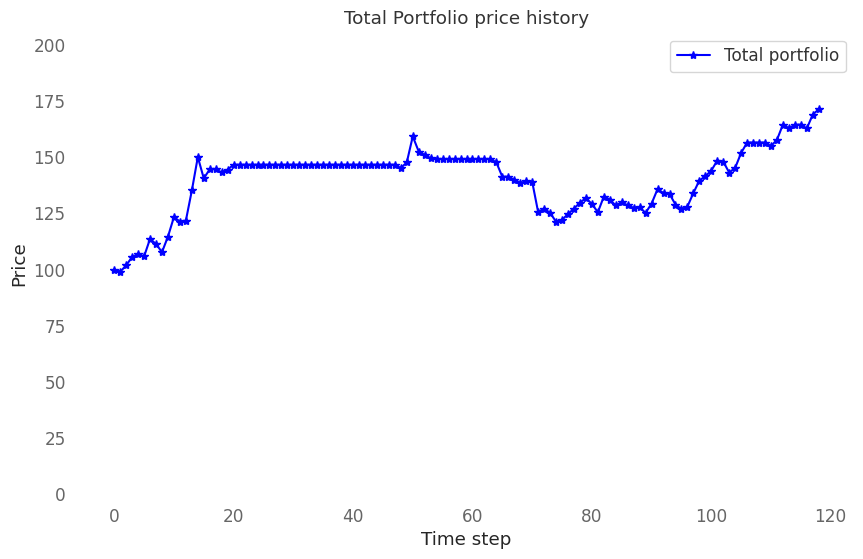

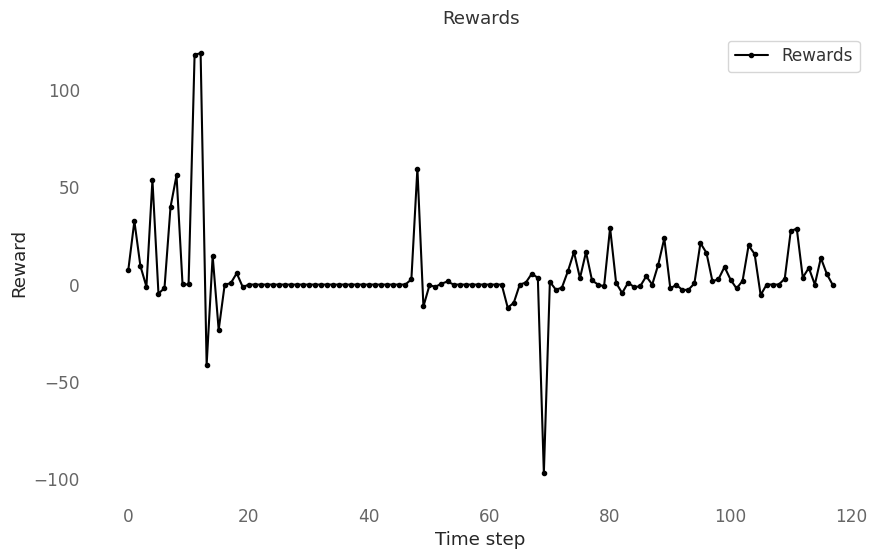

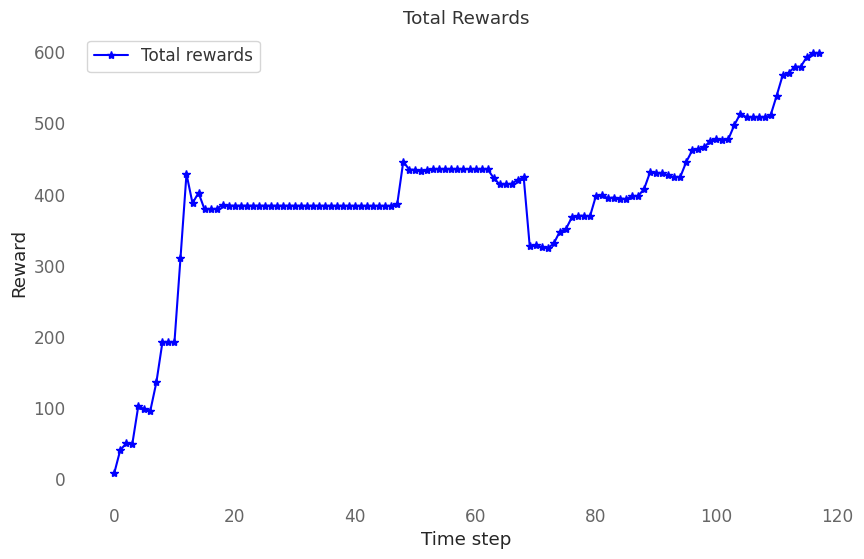

Total rewards: 598.3829532667954
Action Counts:
6    51
5    42
4    20
1     5
Name: count, dtype: int64
BC
Total return of portfolio: -35.28%


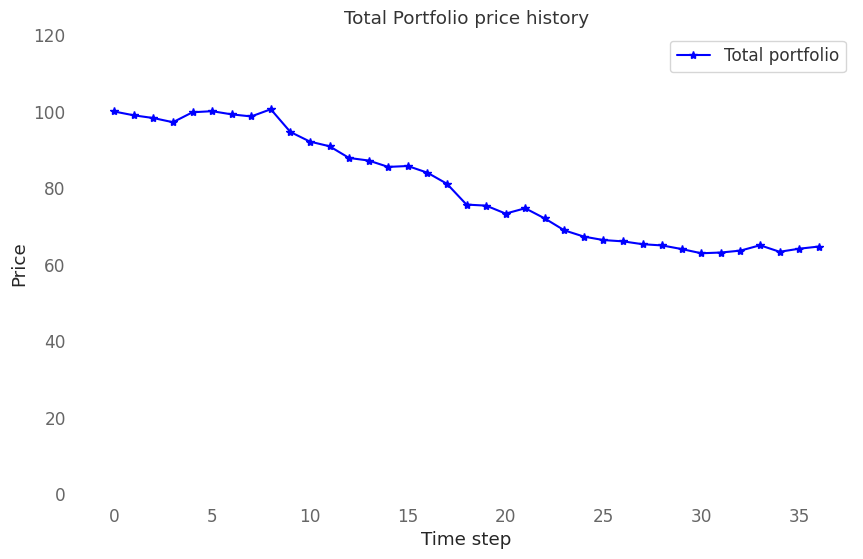

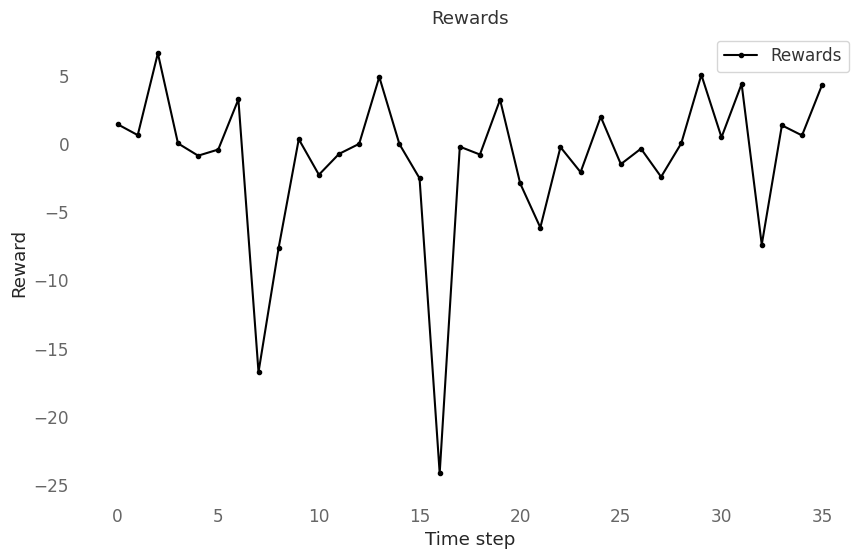

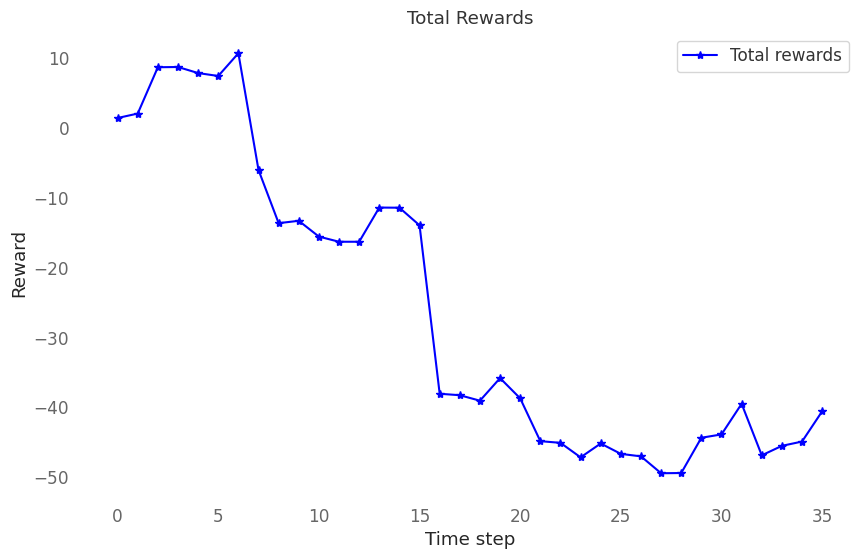

Total rewards: -40.58580009337715
Action Counts:
1    12
0    11
2     6
4     5
5     1
3     1
Name: count, dtype: int64
Best
Total return of portfolio: 1054.23%


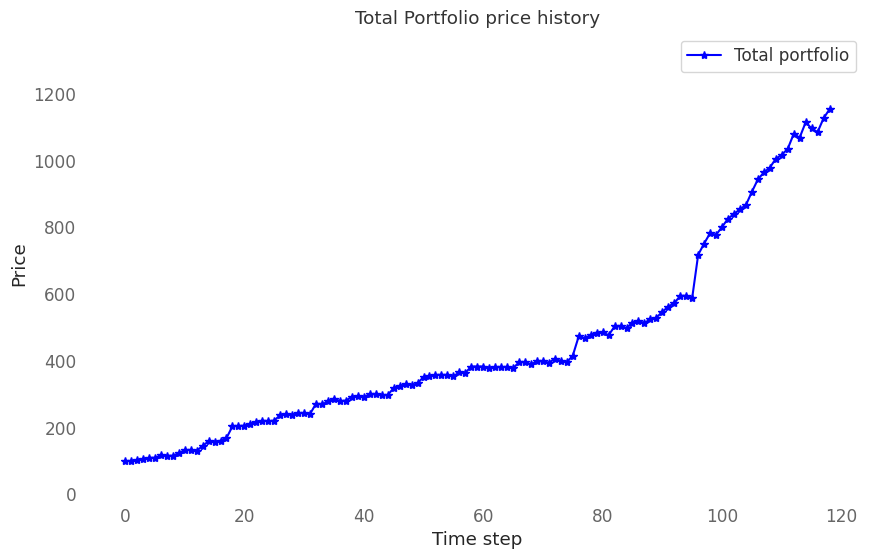

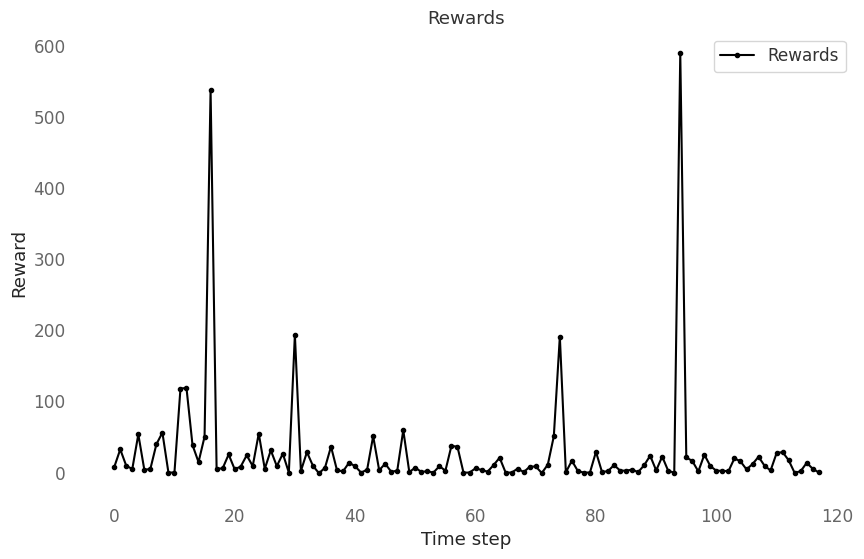

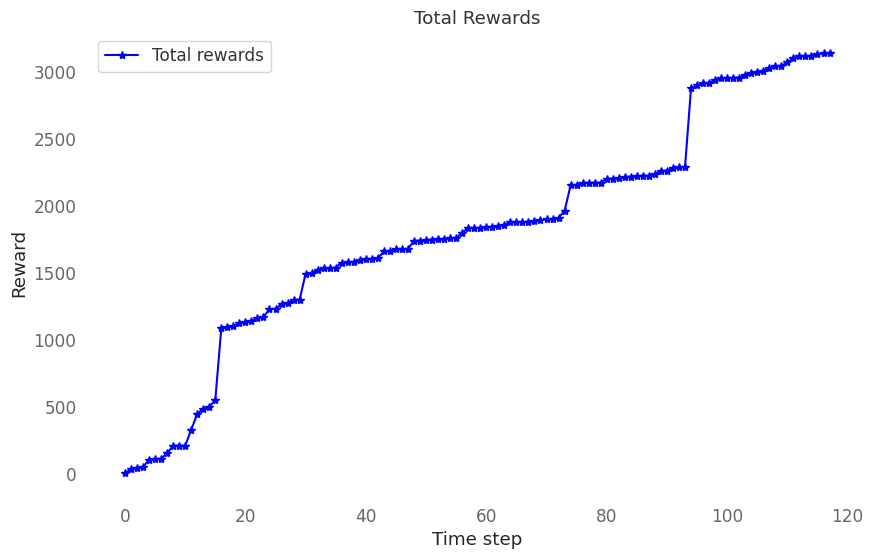

Total rewards: 3139.7045848023267
Action Counts:
5    35
4    24
6    24
1    16
2    10
3     7
0     2
Name: count, dtype: int64


In [26]:
# Initialize the Behavior Cloning (BC) model
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    rng=np.random.default_rng(SEED),
    batch_size=118,
)

# Evaluate the BC policy before training
env.reset(SEED)
mean_reward_bc_before, std_reward_bc_before = evaluate_policy(
    bc_trainer.policy, env, n_eval_episodes=1, return_episode_rewards=False, deterministic=True
)
print("BC Learner rewards before training:")
print(f"Mean reward: {mean_reward_bc_before} +/- {std_reward_bc_before:.2f}")

# Train the BC model with the expert data
bc_trainer.train(
    #n_epochs=100_000,
    n_batches=10_000,
    log_interval=1_000,
    #log_rollouts_n_episodes=10,
    progress_bar=False
)

# Evaluate the BC policy after training
env.reset(SEED)
mean_reward_bc_after, std_reward_bc_after = evaluate_policy(
    bc_trainer.policy, env, n_eval_episodes=1, return_episode_rewards=False, deterministic=True
)
print("BC Learner rewards after training:")
print(f"Mean reward: {mean_reward_bc_after} +/- {std_reward_bc_after:.2f}")

model_actions, returns, total_reward = evaluate_model(env, name="BC",has_policy=True,SEED=SEED,trainer=bc_trainer)
action_counts = pd.Series(model_actions).value_counts()
print("Action Counts:")
print(action_counts)
model_actions, returns, total_reward = evaluate_model(valid_env, name="BC",has_policy=True,SEED=SEED,trainer=bc_trainer)
action_counts = pd.Series(model_actions).value_counts()
print("Action Counts:")
print(action_counts)
best_actions, best_returns, total_reward = evaluate_best(env, expert_actions_list, SEED)
action_counts = pd.Series(best_actions).value_counts()
print("Action Counts:")
print(action_counts)

In [10]:
# Close environments
env.close()
valid_env.close()
vec_env.close()
vec_valid_env.close()

KeyboardInterrupt: 

[0.         1.52929424 1.88253569 0.79456    0.04772727 6.65937738]
Total return of portfolio: 61.54%


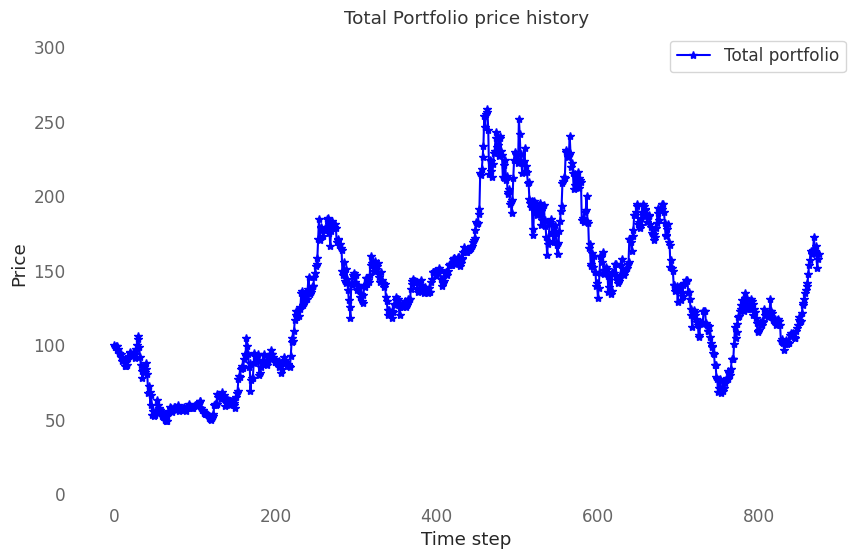

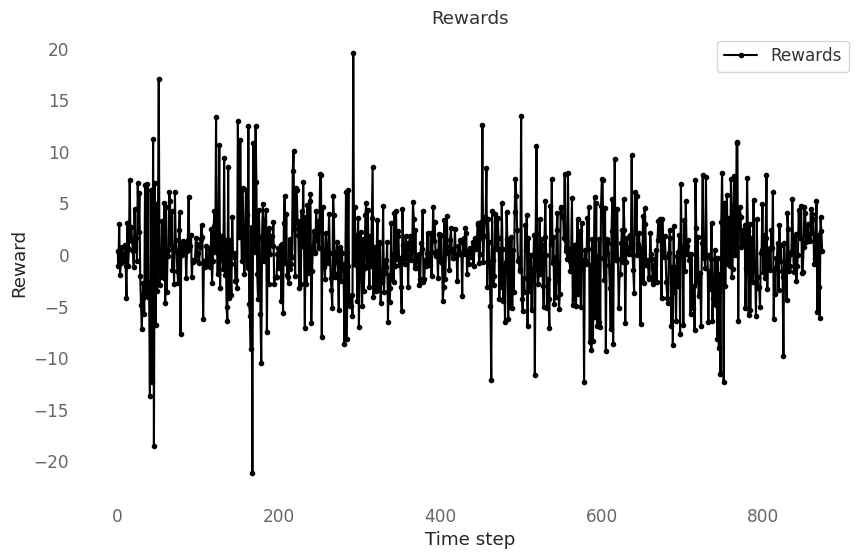

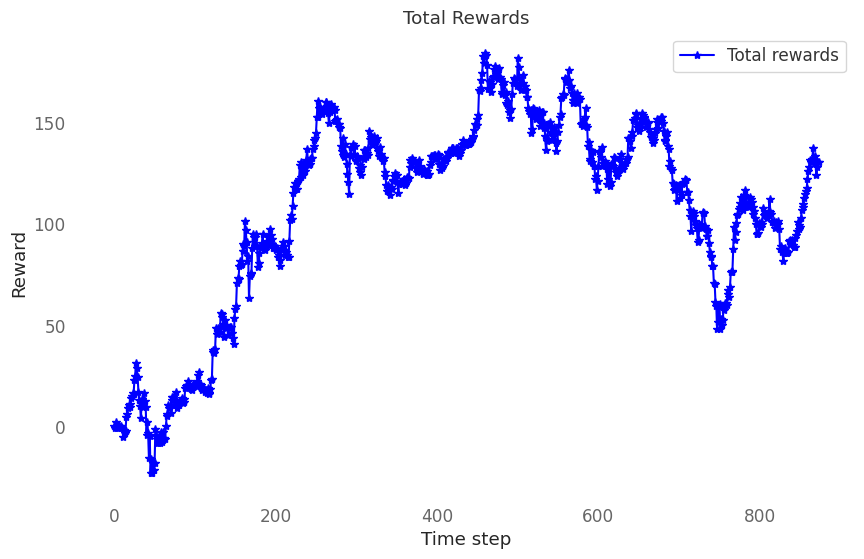

Total rewards: 130.92679714250713


<bound method Env.close of <__main__.TradingEnvUniqueMultiple object at 0x7f791918c340>>

In [17]:
# Download stock data
start_date = '2020-01-01'
end_date = '2023-06-30'
stocks = ['AAPL','AMZN','META','MSFT','NVDA','TSLA']
env, env_fn, date_interval, scalers, df, df_unscaled = create_env(5, 'LNR', start_date, end_date, stocks, True, [])
obs, _ = env.reset()
check_env(env)
obs, _ = env.reset()
percentage_changes = (env.df_unscaled.iloc[100 + 5-1]['Close'].pct_change() + 1).fillna(0).values
print(percentage_changes)
has_policy=True
i = 0
model_actions = []
observation, info = env.reset(seed=42)
total_reward = 0
while True:
    if has_policy:
        action = bc_trainer.policy.predict(observation, deterministic=True)[0]
    else:
        action = bc_trainer.predict(observation, deterministic=True)[0]
    model_actions.append(action)
    observation, reward, done, _, _ = env.step(action)
    total_reward += reward
    i += 1
    if done:
        break
returns = env.returns()
env.render(mode='total')
env.render(mode='rewards')
env.close